In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from plotly.offline import init_notebook_mode,iplot
import cufflinks as cf
import plotly.graph_objs as go
import plotly.figure_factory as ff
init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(offline=False, world_readable=True, theme='ggplot')

### Download and Load Glass Identification data set 

[click here](https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data) to download

Goal is to classify the glass type into 7 categories based on 9 chemical values like Na,Mg,Al...

In [202]:
df=pd.read_csv('data.txt',sep=',',header=None)

In [203]:
names=['building_windows_float_processed','building_windows_non_float_processed ','vehicle_windows_float_processed','containers','tableware','headlamps']
columns=['Id','RI','Na','Mg','Al','Si',"K",'Ca','Ba',"Fe",'Type']

In [204]:
df.columns=columns

In [205]:
df=df.sample(frac=1)

In [206]:
df.set_index('Id',inplace=True)

In [207]:
df.sample(5)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
Id,,,,,,,,,,
201,1.51508,15.15,0.00,2.25,73.50,0.00,8.34,0.63,0.00,7
111,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.00,0.00,2
68,1.52152,13.05,3.65,0.87,72.32,0.19,9.85,0.00,0.17,1
115,1.51847,13.10,3.97,1.19,72.44,0.60,8.43,0.00,0.00,2
83,1.51646,13.41,3.55,1.25,72.81,0.68,8.10,0.00,0.00,2


In [208]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 12 to 117
Data columns (total 10 columns):
RI      214 non-null float64
Na      214 non-null float64
Mg      214 non-null float64
Al      214 non-null float64
Si      214 non-null float64
K       214 non-null float64
Ca      214 non-null float64
Ba      214 non-null float64
Fe      214 non-null float64
Type    214 non-null int64
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


DataSet contains total 214 rows and **None** contains `NaN` or `null` values  

## View class distribution in dataset

In [210]:
df_class=pd.DataFrame(df['Type'])

In [211]:
df.drop(columns=['Type'],inplace=True)

In [212]:
for i in range(df_class.shape[0]):
    if df_class.iloc[i]['Type'] >=5:
        df_class.iloc[i]['Type']-=2
    else:
        df_class.iloc[i]['Type']-=1

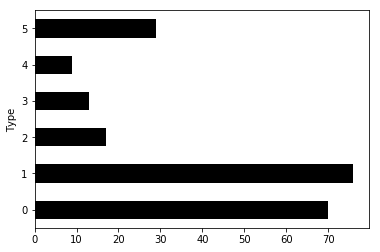

In [213]:
%matplotlib inline
df_class.groupby('Type')['Type'].aggregate('count').plot(kind='barh',colormap='gist_heat')

From above plot,classes are distributed unequally and imbalanced.

In [83]:
df['id']=df.index
figure = ff.create_scatterplotmatrix(
    df,
    diag='box',#(scatter,histogram,box)
    index='id',
    colormap='YlGnBu',
    colormap_type='seq',
    height=1500,
    width=1500)
iplot(figure)
df.drop(columns=['id'],inplace=True)

## Scale data using StandardScaler

In [214]:
from sklearn import preprocessing

In [215]:
scaler=preprocessing.StandardScaler(copy=False)
scaler.fit(df)
scaler.transform(df)

array([[-0.24273229, -0.74610951,  0.67786267, ..., -0.2795857 ,
        -0.35287683, -0.5864509 ],
       [-0.28563998, -0.72156039,  0.60142249, ..., -0.3077582 ,
        -0.35287683,  1.36806497],
       [-0.69821392, -0.05873433,  0.62226982, ..., -0.52609504,
        -0.35287683, -0.5864509 ],
       ...,
       [-0.08430389, -0.5497166 ,  0.19142517, ..., -0.11759384,
        -0.07065073, -0.5864509 ],
       [ 5.13723188, -1.35983734, -1.86551055, ...,  5.09431802,
        -0.35287683,  1.88241125],
       [-0.02489325, -0.20602901,  0.84464125, ..., -0.4556638 ,
        -0.35287683,  0.44224166]])

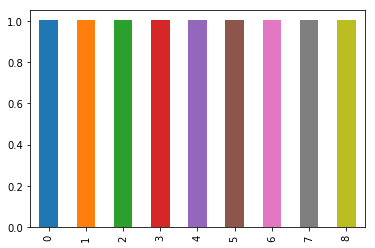

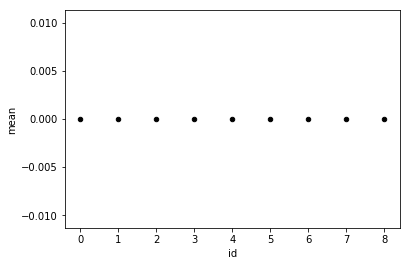

In [216]:
dlf=pd.DataFrame(np.array(df.aggregate('mean').copy()),columns=['mean'])
dlf['id']=dlf.index
dlf['std']=df.std(axis=0).tolist()
dlf['std'].plot(kind='bar')
dlf.plot(kind='scatter',x='id',y='mean',color='black')

All features are centered around Mean=`0` and Standard Deviation=`1`

## Stratified K-Fold splitting of Train and Test sets for equal distribution as classes are imbalanced

In [217]:
from sklearn.model_selection import StratifiedKFold

In [218]:
k_fold=StratifiedKFold(5)

In [219]:
train_arr_ind=np.array([])
test_arr_ind=None
for train_ind,test_ind in k_fold.split(np.array(df),np.array(df_class).reshape(-1,1)):
    print(pd.DataFrame(df_class.iloc[test_ind].groupby('Type')['Type'].aggregate('count')))
    if test_ind[0]==0:
        test_arr_ind=test_ind.reshape(-1,1)
    else:
        train_arr_ind=np.vstack((train_arr_ind.reshape(-1,1),test_ind.reshape(-1,1)))

      Type
Type      
0       14
1       16
2        4
3        3
4        2
5        6
      Type
Type      
0       14
1       15
2        4
3        3
4        2
5        6
      Type
Type      
0       14
1       15
2        3
3        3
4        2
5        6
      Type
Type      
0       14
1       15
2        3
3        2
4        2
5        6
      Type
Type      
0       14
1       15
2        3
3        2
4        1
5        5


In [220]:
print("Train_Set = {0} rows \nTest_Set = {1} rows".format(train_arr_ind.shape[0],test_arr_ind.shape[0]))

Train_Set = 169 rows 
Test_Set = 45 rows


In [221]:
X_train=df.iloc[np.squeeze(train_arr_ind)]
Y_train=df_class.iloc[np.squeeze(train_arr_ind)]
X_test=df.iloc[np.squeeze(test_arr_ind)]
Y_test=df_class.iloc[np.squeeze(test_arr_ind)]

print("Is X and Y for Train and Test equal?")
X_train.shape[0] == Y_train.shape[0] and X_test.shape[0] == Y_test.shape[0]

Is X and Y for Train and Test equal?


True

Since there are only `214` rows of data,for effective testing split data with equal distribution of classes 

## One_Hot Encode the class lables

In [222]:
one_hot=preprocessing.OneHotEncoder(categories='auto')

In [223]:
one_hot.fit(Y_train)

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [224]:
Y_train_labels=one_hot.transform(Y_train).toarray()

In [225]:
one_hot.fit(Y_test)

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [226]:
Y_test_labels=one_hot.transform(Y_test).toarray()

## Softmax Regression

In [27]:
def relu(x):
    x[x<0]=0
    return x

def sigmoid(x):
    return 1/(1+np.exp(-x))

def softmax(x):
    shift=x-np.max(x)
    exps=np.exp(shift)
    return np.exp(shift)/np.sum(exps,axis=0,keepdims=True)

def relu_backward(x):
    x[x>0]=1
    return x

def sigmoid_backward(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax_backward(a,y):
    return a-y

def cost(Y,A):
    m=Y.shape[1]
    cross_entropy=-np.sum(np.log(A)*Y)
    return (1/m)*cross_entropy

def class_label(z):
    return np.argmax(z,axis=0)

def accuracy(pred,y):
    co=0
    for i in range(len(pred)):
        if y[i] == pred[i]:
            co+=1
    return co/len(pred)

In [28]:
def initialize_parameters(n_layers,n_hidden):
    W={}
    b={}
    V={}
    S={}
    np.random.seed(2)
    for i in range(n_layers):
        if i ==0:
            w=np.random.randn(n_hidden,X_train.shape[1])*np.sqrt(2/X_train.shape[1])
            bb=np.zeros((n_hidden,1))
            W['W' + str(i+1)]=w
            b['b' + str(i+1)]=bb
        elif i==(n_layers-1):
            w=np.random.randn(n_classes,n_hidden)*np.sqrt(2/n_hidden)
            bb=np.zeros((n_classes,1))
            W['W' + str(i+1)]=w
            b['b' + str(i+1)]=bb
        else:
            w=np.random.randn(n_hidden,n_hidden)*np.sqrt(2/n_hidden)
            bb=np.zeros((n_hidden,1))
            W['W' + str(i+1)]=w
            b['b' + str(i+1)]=bb
        V["dW"+str(i+1)]=np.zeros_like(W['W'+str(i+1)])
        V["db"+str(i+1)]=np.zeros_like(b['b'+str(i+1)])
        S["dW"+str(i+1)]=np.zeros_like(W['W'+str(i+1)])
        S["db"+str(i+1)]=np.zeros_like(b['b'+str(i+1)])
    return W,b,V,S

In [29]:
def forward_prop(X,W,b,keep_prob=0.8):
    A={}
    D={}
    Z={}
    A['A0']=X
    np.random.seed(0)
    for i in range(n_layers):
        z=np.dot(W['W'+str(i+1)],A['A'+str(i)]) + b['b'+str(i+1)]
        a=None
        if(i < n_layers-1):
            a=relu(z)
        else:
            a=softmax(z)
        d=np.random.rand(a.shape[0],a.shape[1])
        d=d < keep_prob
        if(i < n_layers-1):
            a=a * d
            a/=keep_prob
        A['A'+str(i+1)]=a
        Z['Z'+str(i+1)]=z
        D['D'+str(i+1)]=d
        cache=[W,b,Z,A,D]
    return cache

In [30]:
def backward_prop(X,Y,cache,keep_prob=0.8):
    W,b,Z,A,D=cache
    DW={}
    Db={}
    DA={}
    DZ={}
    m=X.shape[1]
    for i in range(n_layers,0,-1):
        if i == n_layers:
            DZ['DZ'+str(i)] = softmax_backward(A['A'+str(i)],Y)
            DW['DW'+str(i)] = (1/m) * np.dot(DZ['DZ'+str(i)],A['A'+str(i-1)].T)
            Db['Db'+str(i)] = (1/m) * np.sum(DZ['DZ'+str(i)],axis=1,keepdims=True)
        else:
            dcost = (1/m) * np.dot(DZ['DZ'+str(i+1)].T,DW['DW'+str(i+1)])
            DZ['DZ'+str(i)] = relu_backward(A['A'+str(i)])
            DW['DW'+str(i)] = (1/m) * np.dot(DZ['DZ'+str(i)] * dcost.T,A['A'+str(i-1)].T)
            Db['Db'+str(i)] = (1/m) * np.sum(DZ['DZ'+str(i)] * dcost.T,axis=1,keepdims=True)
        if i-1 != 0:
            DA['DA'+str(i-1)] = np.dot(DW['DW'+str(i)].T,DZ['DZ'+str(i)])
            DA['DA'+str(i-1)] = DA['DA'+str(i-1)] * D['D'+str(i-1)]
            DA['DA'+str(i-1)] /= keep_prob
    return [DW,Db,DZ,DA]

In [31]:
def update(cache,cache_d,eta=0.1):
    W,b=cache[0],cache[1]
    DW,Db=cache_d[0],cache_d[1]
    for i in range(n_layers):
        W['W'+str(i+1)] -= eta * DW['DW'+str(i+1)]
        b['b'+str(i+1)] -= eta * Db['Db'+str(i+1)]
    return W,b

In [32]:
def model(X,Y,num_iter,eta):
    W,b,V,S=initialize_parameters(n_layers,n_hidden)
    for i in tqdm(range(num_iter)):
        cache=forward_prop(X.T,W,b)
        loss=cost(Y.T,cache[3]['A'+str(n_layers)])
        cache_d=backward_prop(X_train.T,Y_train_labels.T,cache)
        cache[0],cache[1]=update(cache,cache_d,eta)
        costs.append(loss)
    return cache

In [93]:
costs=[]
num_iter=5001
n_layers=20
n_hidden=100
n_classes=6
eta=0.1
cache=model(X_train,Y_train_labels,num_iter,eta)

100%|██████████████████████████████████████████████████████████████████████████████| 5001/5001 [03:01<00:00, 27.57it/s]


    Total Time Taken = 3m 01s

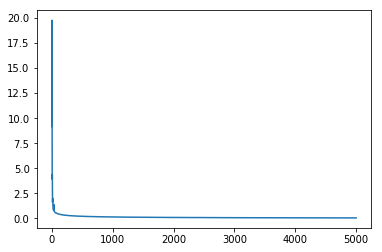

In [94]:
plt.plot(np.arange(num_iter),costs)

            No.of Iterations v/s Loss

In [95]:
for i in range(len(costs)):
    if i%500 == 0 :
        print('Training Error after iteration-{0:<4} = {1} ' . format(i,costs[i]))

Training Error after iteration-0    = 9.18042743536985 
Training Error after iteration-500  = 0.2012267156778126 
Training Error after iteration-1000 = 0.13467699015810175 
Training Error after iteration-1500 = 0.10407707742646587 
Training Error after iteration-2000 = 0.08538904063580213 
Training Error after iteration-2500 = 0.07245787913248608 
Training Error after iteration-3000 = 0.06288620856544631 
Training Error after iteration-3500 = 0.055494692290850675 
Training Error after iteration-4000 = 0.049612755201711496 
Training Error after iteration-4500 = 0.04482317852973904 
Training Error after iteration-5000 = 0.040850433010622016 


In [96]:
pred=class_label(cache[3]['A'+str(n_layers)])

In [103]:
accuracy(pred,Y_train.values)

1.0

    Training Error    = 0.0408
    Training Accuracy = 1.0

In [98]:
cache_test=forward_prop(X_test.T,cache[0],cache[1])

In [99]:
pred_test=class_label(cache_test[3]['A'+str(n_layers)])

In [104]:
accuracy(pred_test,Y_test.values)

0.2

## BatchNormalization and Adam Optimization

In [33]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [252]:
def build_model(par):
    model=Sequential()
    model.add(Dense(units=par['units'],input_dim=par['input_dim'],kernel_initializer=par['initializer'],name='l1'))
    model.add(BatchNormalization())
    model.add(Activation(par['activation']))
    model.add(Dropout(1-par['keep_prob']))
    for i in range(1,par['n_layers']):
        model.add(Dense(units=par['units'],kernel_initializer=par['initializer'],name='l'+str(i+1)))
        model.add(BatchNormalization())
        model.add(Activation(par['activation']))
        model.add(Dropout(1-par['keep_prob']))
    model.add(Dense(units=par['output_dim'],kernel_initializer=par['initializer'],name='l'+str(par['n_layers']+1)))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.compile(loss=par['loss'],optimizer=par['optimizer'],metrics=[par['accuracy']])
    return model

In [259]:
param=dict()
param['n_layers']=20
param['units']=100
param['input_dim']=X_train.shape[1]
param['initializer']='he_uniform'
param['activation']='relu'
param['keep_prob']=0.8
param['output_dim']=6
param['loss']='categorical_crossentropy'
param['optimizer']='adam'
param['accuracy']='categorical_accuracy'

In [444]:
model=build_model(param)
model.fit(X_train,Y_train_labels,epochs=5000,verbose=False)

In [136]:
model.metrics_names

['loss', 'categorical_accuracy']

In [445]:
train_loss,train_accuracy=model.evaluate(X_train,Y_train_labels)

169/169 [==============================] - ETA:  - 2s 13ms/step


In [446]:
print('Train Loss:{0}\nTrain Accuracy:{1}'.format(train_loss,train_accuracy))

Train Loss:0.1733022334836644
Train Accuracy:0.9763313609467456


In [447]:
test_loss,test_accuracy=model.evaluate(X_test,Y_test_labels)

45/45 [==============================] - ETA:  - 0s 288us/step


In [448]:
print('Test Loss:{0}\nTest Accuracy:{1}'.format(test_loss,test_accuracy))

Test Loss:0.8693163090282017
Test Accuracy:0.7555555582046509


In [449]:
cls=model.predict(X_test)

In [450]:
pred_test_classes=class_label(cls.T)

In [451]:
from collections import Counter
miss_label=Counter()
for i,j in zip(pred_test_classes,np.squeeze(Y_test.values)):
    if i!=j:
        print('Predicted : {} |||| {} : Actual'.format(i,j) )
        miss_label[j] = miss_label[j] + 1

Predicted : 0 |||| 1 : Actual
Predicted : 2 |||| 1 : Actual
Predicted : 2 |||| 0 : Actual
Predicted : 0 |||| 1 : Actual
Predicted : 1 |||| 2 : Actual
Predicted : 0 |||| 1 : Actual
Predicted : 1 |||| 3 : Actual
Predicted : 1 |||| 3 : Actual
Predicted : 0 |||| 1 : Actual
Predicted : 0 |||| 2 : Actual
Predicted : 1 |||| 5 : Actual


## Apply PCA

In [452]:
corr=df.corr()

In [453]:
figure = ff.create_annotated_heatmap(
    z=abs(corr.values),
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=abs(corr.round(2).values),
    colorscale='Electric',
    showscale=True)
iplot(figure)

As there is some correlation between features PCA can be applied.

In [454]:
from sklearn.decomposition import PCA

In [455]:
pca=PCA(random_state=2)
pca.fit(df)
var_exp=pca.explained_variance_ratio_
cum_var_exp=np.cumsum(var_exp)
trace1=go.Bar(x=np.arange(1,var_exp.shape[0]+1),y=var_exp,name='Variance',marker=dict(color=np.random.randn(var_exp.shape[0]),colorscale='Reds'))
trace2=go.Scatter(x=np.arange(1,cum_var_exp.shape[0]+1),y=cum_var_exp,mode='markers+lines+text',line=dict(shape='hv',color='ivory'),name='Cumm_Variance',text=cum_var_exp.round(4),textposition='top left')
data=[trace1,trace2]
layout=go.Layout(xaxis=dict(title='Principle Components'),yaxis=dict(title='Explained Variance'),plot_bgcolor='black',paper_bgcolor='mediumpurple')
fig=go.Figure(data=data,layout=layout)
iplot(fig)

    Select 7 Principle Components which explains 99.2% variance

In [456]:
pca_n=PCA(n_components=7)
df_red=pd.DataFrame(pca_n.fit_transform(df))

In [457]:
k_fold=StratifiedKFold(5)
train_arr_ind_red=np.array([])
test_arr_ind_red=None
for train_ind,test_ind in k_fold.split(np.array(df_red),np.array(df_class).reshape(-1,1)):
    if test_ind[0]==0:
        test_arr_ind_red=test_ind.reshape(-1,1)
    else:
        train_arr_ind_red=np.vstack((train_arr_ind.reshape(-1,1),test_ind.reshape(-1,1)))

X_train_red=df_red.iloc[np.squeeze(train_arr_ind)]
Y_train_red=df_class.iloc[np.squeeze(train_arr_ind)]
X_test_red=df_red.iloc[np.squeeze(test_arr_ind)]
Y_test_red=df_class.iloc[np.squeeze(test_arr_ind)]

In [458]:
one_hot=preprocessing.OneHotEncoder(categories='auto')
one_hot.fit(Y_train_red)
Y_train_labels_red=one_hot.transform(Y_train_red).toarray()
one_hot.fit(Y_test_red)
Y_test_labels_red=one_hot.transform(Y_test).toarray()

In [459]:
param_red=dict()
param_red['n_layers']=20
param_red['units']=100
param_red['input_dim']=X_train_red.shape[1]
param_red['initializer']='he_uniform'
param_red['activation']='relu'
param_red['keep_prob']=0.8
param_red['output_dim']=6
param_red['loss']='categorical_crossentropy'
param_red['optimizer']='adam'
param_red['accuracy']='accuracy'

In [460]:
model_red=build_model(param_red)
bf=time.time()
history=model_red.fit(X_train_red,Y_train_labels_red,epochs=2400,validation_data=(X_test_red,Y_test_labels_red),verbose=False)
af=time.time()

In [461]:
print("Time Taken(s):",af-bf)

Time Taken(s): 300.31795477867126


In [462]:
train_loss_red=np.array(history.history['loss'])
test_loss_red=np.array(history.history['val_loss'])
trace1=go.Scatter(y=np.sort(train_loss_red)[::-1],name='Train Loss')
trace2=go.Scatter(y=np.sort(test_loss_red)[::-1],name='Test Loss')
layout=go.Layout(title='Iteration Vs Loss',xaxis=dict(range=[0,2500],title='Iteration'),yaxis=dict(range=[0,2.5],title='Loss'))
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
iplot(fig)

In [463]:
train_acc_red=np.array(history.history['acc'])
test_acc_red=np.array(history.history['val_acc'])
trace1=go.Scatter(y=np.sort(train_acc_red),name='Train Accuracy')
trace2=go.Scatter(y=np.sort(test_acc_red),name='Test Accuracy')
layout=go.Layout(title='Iteration Vs Accuracy',xaxis=dict(range=[0,2500],title='Iteration'),yaxis=dict(range=[0,1],title='Accuracy'))
data=[trace1,trace2]
fig=go.Figure(data=data,layout=layout)
iplot(fig)

### Performance

In [464]:
train_loss_red,train_accuracy_red=model_red.evaluate(X_train_red,Y_train_labels_red)
test_loss_red,test_accuracy_red=model_red.evaluate(X_test_red,Y_test_labels_red)

45/45 [==============================] - ETA:  - 0s 310us/step


In [465]:
print('Train Loss:{0}\nTrain Accuracy:{1}'.format(train_loss_red,train_accuracy_red))

Train Loss:0.4699401774350003
Train Accuracy:0.869822485912481


In [470]:
print('Test Loss:{0}\nTest Accuracy:{1}'.format(test_loss_red,test_accuracy_red))

Test Loss:0.878775246938069
Test Accuracy:0.800222817514208


In [398]:
cls_red=model_red.predict(X_test_red)
pred_test_classes_red=class_label(cls_red.T)
from collections import Counter
miss_label=Counter()
for i,j in zip(pred_test_classes_red,np.squeeze(Y_test_red.values)):
    if i!=j:
        print('Predicted : {} |||| {} : Actual'.format(i,j) )
        miss_label[j] = miss_label[j] + 1

Predicted : 0 |||| 1 : Actual
Predicted : 0 |||| 2 : Actual
Predicted : 0 |||| 1 : Actual
Predicted : 0 |||| 2 : Actual
Predicted : 0 |||| 2 : Actual
Predicted : 0 |||| 1 : Actual
Predicted : 0 |||| 2 : Actual
Predicted : 1 |||| 5 : Actual


### Confusion Matrix

In [401]:
from sklearn.metrics import confusion_matrix

In [405]:
result=confusion_matrix(np.squeeze(Y_test_red.values),pred_test_classes_red)

In [439]:
figure = ff.create_annotated_heatmap(
    z=result,
    x=[0,1,2,3,4,5],
    y=[0,1,2,3,4,5],
    colorscale='Reds',
    showscale=False)
figure['layout'].update(xaxis=dict(title='Predicted'))
figure['layout'].update(yaxis=dict(title='Actual'))
iplot(figure)

## Final Word

    Notebook Outflow:
        1.Data load and little EDA
        2.Standardize data
        3.Stratified K-Fold
        4.One-Hot Encoding
        5.Softmax Regression without BatchNormalization
        6.BatchNormalization and Adam Optimization in Keras
        7.PCA for better performance
        8.Again same model with keras applied on Prinicple Componets

<pre>
<b>Test Accuracy:</b><br>
  <b>Softmax Regression without BatchNormalization</b>               - 0.2
  <b>Softmax Regression With BatchNormalization</b>                  - 0.755
  <b>Softmax Regression with BatchNormalization and applying PCA</b> - 0.80</pre>

    Model Accuracy can be furthur imporved using more layers,tuning hyperparameters,gathering more data(may not possible).